### Planning

- README is in a good position

### Acquisition

Need: 
- properties_2017: bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, fips, lotsizesquarefeet, taxvaluedollarcnt, yearbuilt, garagecarcnt, garagetotalsqft, transactiondate
- predictions_2017: join using parcelid
- propertylandusetype tables: join using 'propertylandusetypeid'

Let's get the env setup

In [3]:
from env import get_db_url
import os
import pandas as pd
import numpy as np

Make the get_zillow function (creates a csv)

In [4]:
def get_zillow():
    '''This function imports zillow 2017 data from MySql codeup server and creates a csv
    
    argument: df
    
    returns: zillow df'''
    filename = "zillow.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        query = """
        SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, lotsizesquarefeet, fips, transactiondate, garagecarcnt, garagetotalsqft
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid like '261';
        """
        connection = get_db_url("zillow")
        df = pd.read_sql(query, connection)
        df.to_csv(filename, index=False)
    return df

It works so copy this over to Wrangle

In [5]:
df = get_zillow()

In [6]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,lotsizesquarefeet,fips,transactiondate,garagecarcnt,garagetotalsqft
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [7]:
df.shape

(52442, 10)

### Preparation

lets see what needs to be cleaned up

create a function to visualize whats in the dataset

In [8]:
def check_columns(df):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, and the data type of the column.
    The resulting dataframe is sorted by the 'Number of Unique Values' column in ascending order.
​
    Args:
    - df: pandas dataframe
​
    Returns:
    - pandas dataframe
    """
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, and data type to the data list
        data.append(
            [
                column,
                df[column].nunique(),
                df[column].unique(),
                df[column].isna().sum(),
                df[column].isna().mean(),
                df[column].dtype
            ]
        )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', and 'dtype'
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "Column Name",
            "Number of Unique Values",
            "Unique Values",
            "Number of Null Values",
            "Proportion of Null Values",
            "dtype"
        ],
    ).sort_values(by="Number of Unique Values")

In [9]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,fips,3,"[6059.0, 6111.0, 6037.0]",0,0.000000,float64
0,bedroomcnt,14,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 0.0, 8.0, ...",0,0.000000,float64
8,garagecarcnt,14,"[2.0, 1.0, nan, 3.0, 4.0, 5.0, 0.0, 7.0, 6.0, ...",34427,0.656478,float64
1,bathroomcnt,22,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",116,0.002212,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garagetotalsqft,839,"[633.0, 0.0, 440.0, nan, 420.0, 447.0, 485.0, ...",34427,0.656478,float64
2,calculatedfinishedsquarefeet,4723,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",82,0.001564,float64
5,lotsizesquarefeet,14292,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",369,0.007036,float64
3,taxvaluedollarcnt,38942,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


Need to rename columns to work with easier

- fips --> county
- bedroomcnt --> bedrooms
- garagecarcnt --> garage_fits
- bathroomcnt --> bathrooms
- garagetotalsqft --> garage_area
- calculatedfinishedsquarefeet --> finished_area
- lotsizesquarefeet --> lot_area
- taxvaluedollarcnt --> home_value

In [10]:
df.rename(columns={'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'}, inplace=True)

In [11]:
df.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,transactiondate,garage_fits,garage_area
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [12]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[6059.0, 6111.0, 6037.0]",0,0.000000,float64
0,bedrooms,14,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 0.0, 8.0, ...",0,0.000000,float64
8,garage_fits,14,"[2.0, 1.0, nan, 3.0, 4.0, 5.0, 0.0, 7.0, 6.0, ...",34427,0.656478,float64
1,bathrooms,22,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",116,0.002212,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, nan, 420.0, 447.0, 485.0, ...",34427,0.656478,float64
2,finished_area,4723,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",82,0.001564,float64
5,lot_area,14292,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",369,0.007036,float64
3,home_value,38942,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


What do I see now?
- county: 
    - change unique values to (6037: 'LA', 6059: 'Orange', 6111: 'Ventura')
    - no nulls


In [13]:
# start with county, change unique values
df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

- bedrooms:
    - change type to int
    - drop 0 bedrooms
    - drop more than 8 bedrooms

In [14]:
df.bedrooms = df.bedrooms.astype(int)

In [15]:
df.bedrooms[df['bedrooms'] <= 8]

0        4
1        2
2        3
3        4
4        4
        ..
52437    2
52438    4
52439    3
52440    3
52441    3
Name: bedrooms, Length: 52427, dtype: int64

In [16]:
df.drop(df[df['bedrooms'] > 8].index, inplace=True)

In [17]:
df.bedrooms.value_counts()

bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
0      137
7      106
8       24
Name: count, dtype: int64

In [18]:
df.drop(df[df['bedrooms'] == 0].index, inplace=True)

In [19]:
df.bedrooms.value_counts()

bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
7      106
8       24
Name: count, dtype: int64

- garage_fits:
    - 65% nan (Assume they have No Garage?)
    - for nan, change value to 0.0
    - change type to int


In [20]:
# garage_fits change nan, dtype=int
df.garage_fits = df.garage_fits.fillna(0).astype(int)

- bathrooms:
    - looks good


- garage_area:
    - 65% nan (Assume the have No Garage?)
    - for nan, change value to 0.0


In [21]:
df.garage_area = df.garage_area.fillna(0)

In [22]:
df.garage_area.value_counts()

garage_area
0.0       34474
400.0       788
441.0       678
462.0       660
360.0       647
          ...  
1296.0        1
221.0         1
301.0         1
2198.0        1
957.0         1
Name: count, Length: 839, dtype: int64

- yearbuilt:
    - 0.02% nulls, drop null values
    - change type to datetime 'year'


In [23]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.000000,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.000000,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.000000,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",40,0.000765,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.000000,float64
2,finished_area,4702,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",8,0.000153,float64
5,lot_area,14236,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",353,0.006751,float64
3,home_value,38825,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


- finished_area:
    - 0.01% null
    - drop null values


- lot_area:
    - 0.07% null
    - drop null values


- home_value:
    - 1 null
    - just drop it


In [24]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.000000,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.000000,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.000000,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",40,0.000765,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.000000,float64
2,finished_area,4702,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",8,0.000153,float64
5,lot_area,14236,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",353,0.006751,float64
3,home_value,38825,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


In [25]:
# take care of null vals for yearbuilt, finished_area, lot_area, and home_value
df = df.dropna()

In [26]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",0,0.0,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.0,object
9,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [27]:
df.shape

(51895, 10)

- transactiondate:
    - type is object...consider changing into just month of transaction
    - only using predictions for the samples so drop column


In [28]:
df.drop(columns='transactiondate', inplace=True)

In [29]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",0,0.0,float64
8,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


Overall, only lose .1% of data by dropping nulls

In [30]:
from env import get_db_url
import os
import pandas as pd
import numpy as np

Combine in a function for prep_zillow()

In [31]:
def prep_zillow(df):
    '''takes the zillow dataframe, drops nulls, drops transactiondate, changes column names, 
    and replaces null values in garage columns

    argument: df

    returns: clean_df
    '''
    # rename columns
    df.rename(columns={'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'}, inplace=True)
    
    # garage_fits change nan, dtype=int, fill nulls for garage_area
    df.garage_fits = df.garage_fits.fillna(0).astype(int)
    df.garage_area = df.garage_area.fillna(0)
    
    # take care of null vals for yearbuilt, finished_area, lot_area, and home_value
    df.dropna(axis=0,inplace=True)
    # change yearbuilt type to int
    df.yearbuilt = df.yearbuilt.astype(int)
    # drop transactiondate
    df = df.drop(columns='transactiondate')
    # start with county, change unique values
    df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})
    # change bedroom dtype to int and drop values 0 and everything above 8
    df['bedrooms'] = df.bedrooms.astype(int)
    df.drop(df[df['bedrooms'] > 8].index, inplace=True)
    df.drop(df[df['bedrooms'] == 0].index, inplace=True)
    
    return df

In [32]:
df = get_zillow()

In [33]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,lotsizesquarefeet,fips,transactiondate,garagecarcnt,garagetotalsqft
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [34]:
df = prep_zillow(df)

In [35]:
df

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
0,4,3.5,3100.0,1023282.0,1998,4506.0,Orange,2,633.0
1,2,1.0,1465.0,464000.0,1967,12647.0,Ventura,1,0.0
2,3,2.0,1243.0,564778.0,1962,8432.0,Orange,2,440.0
3,4,3.0,2376.0,145143.0,1970,13038.0,LA,0,0.0
4,4,3.0,2962.0,773303.0,1950,63000.0,LA,0,0.0
...,...,...,...,...,...,...,...,...,...
52437,2,2.0,1286.0,354621.0,1940,47405.0,LA,0,0.0
52438,4,2.0,1612.0,67205.0,1964,12105.0,Ventura,2,560.0
52439,3,1.0,1032.0,49546.0,1954,5074.0,LA,0,0.0
52440,3,2.0,1762.0,522000.0,1955,6347.0,LA,0,0.0


In [36]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998, 1967, 1962, 1970, 1950, 1922, 1999, 198...",0,0.0,int64
8,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [37]:
# need to drop houses with no bedrooms
# need to drop houses with more than 8 bedrooms
df.bedrooms.value_counts()

bedrooms
3    23269
4    15113
2     8265
5     3916
6      627
1      578
7      103
8       24
Name: count, dtype: int64

In [38]:
# drops the bottom 1% and the top 1% to deal with outliers
bottom_perc = df.home_value.quantile(.01)
top_perc = df.home_value.quantile(.99)
df = df[(df.home_value > bottom_perc) & (df.home_value < top_perc)]


In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,50857.0,3.304756,0.907487,1.0,3.0,3.0,4.0,8.0
bathrooms,50857.0,2.280060,0.950156,0.0,2.0,2.0,3.0,10.0
finished_area,50857.0,1891.569125,893.162772,152.0,1274.0,1657.0,2286.0,11020.0
home_value,50857.0,481530.479305,434360.823751,37430.0,197299.0,372912.0,609150.0,3076800.0
yearbuilt,50857.0,1963.435437,22.706214,1878.0,1950.0,1961.0,1979.0,2016.0
lot_area,50857.0,11070.894253,87329.684645,236.0,5595.0,6831.0,8719.0,6971010.0
garage_fits,50857.0,0.678668,0.975724,0.0,0.0,0.0,2.0,14.0
garage_area,50857.0,172.567572,251.251988,0.0,0.0,0.0,433.0,4251.0


In [40]:
import wrangle as w

In [41]:
df = w.get_zillow()

In [42]:
df = w.prep_zillow(df)

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,50841.0,3.304911,0.907431,1.0,3.0,3.0,4.0,8.0
bathrooms,50841.0,2.280758,0.949481,1.0,2.0,2.0,3.0,10.0
finished_area,50841.0,1891.458606,893.010819,152.0,1274.0,1657.0,2286.0,11020.0
home_value,50841.0,481543.801046,434316.463331,37431.0,197341.0,372917.0,609150.0,3076800.0
yearbuilt,50841.0,1963.433961,22.705263,1878.0,1950.0,1961.0,1979.0,2016.0
lot_area,50841.0,11065.639740,87341.829496,236.0,5595.0,6830.0,8716.0,6971010.0
garage_fits,50841.0,0.678389,0.975550,0.0,0.0,0.0,2.0,14.0
garage_area,50841.0,172.487343,251.199144,0.0,0.0,0.0,433.0,4251.0


### Exploration and Pre-Processing

Prep is done, Now I need to split into train, validate, test

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
def split_data(df):
    '''
    split continuouse data into train, validate, test; No target variable

    argument: df

    return: train, validate, test
    '''

    train_val, test = train_test_split(df,
                                   train_size=0.8,
                                   random_state=1108,
                                   )
    train, validate = train_test_split(train_val,
                                   train_size=0.7,
                                   random_state=1108,
                                   )
    
    print(f'Train: {len(train)/len(df)}')
    print(f'Validate: {len(validate)/len(df)}')
    print(f'Test: {len(test)/len(df)}')
    

    return train, validate, test

In [46]:
train, validate, test = split_data(df)

Train: 0.5599811176019355
Validate: 0.2400031470663441
Test: 0.20001573533172046


In [47]:
train.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
9449,3,3.0,1640.0,238697.0,1956,7119.0,LA,0,0.0
28696,3,2.0,1710.0,457000.0,1964,7811.0,LA,0,0.0
11759,3,3.0,2180.0,274015.0,2014,6636.0,LA,0,0.0
25505,4,3.0,2260.0,609150.0,1991,6749.0,LA,0,0.0
31727,3,2.0,1571.0,115576.0,1954,7597.0,LA,0,0.0


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
columns = train.drop(columns='county').columns

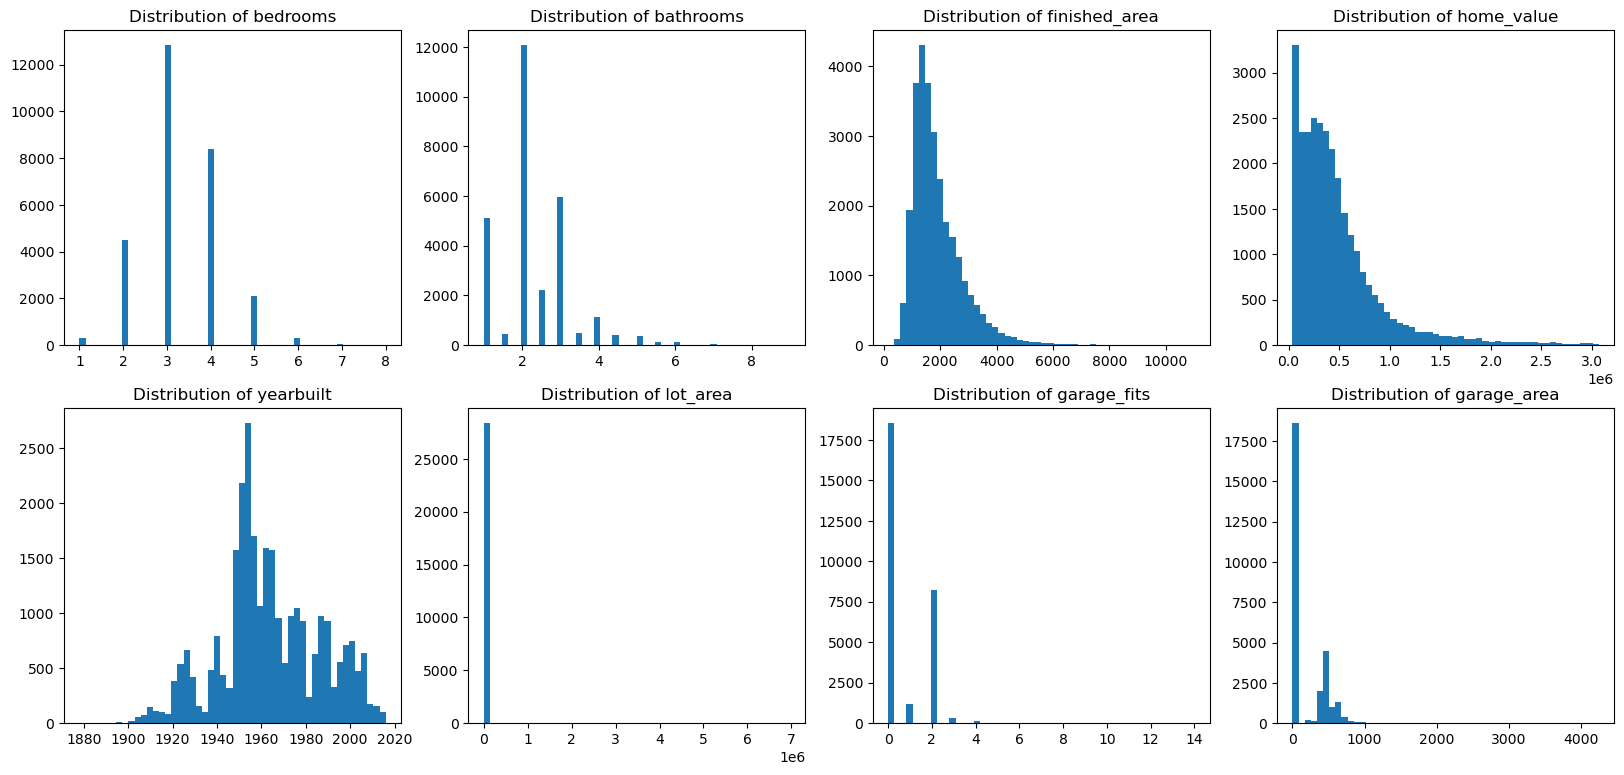

In [50]:
# visualize univariate distributions:
plt.figure(figsize=(20,9))
for i, col in enumerate(columns):
    subplot_num = i+1
    plt.subplot(2,4,subplot_num)
    plt.title(f'Distribution of {col}')
    train[col].hist(bins=50)
    plt.grid(False)
plt.show()

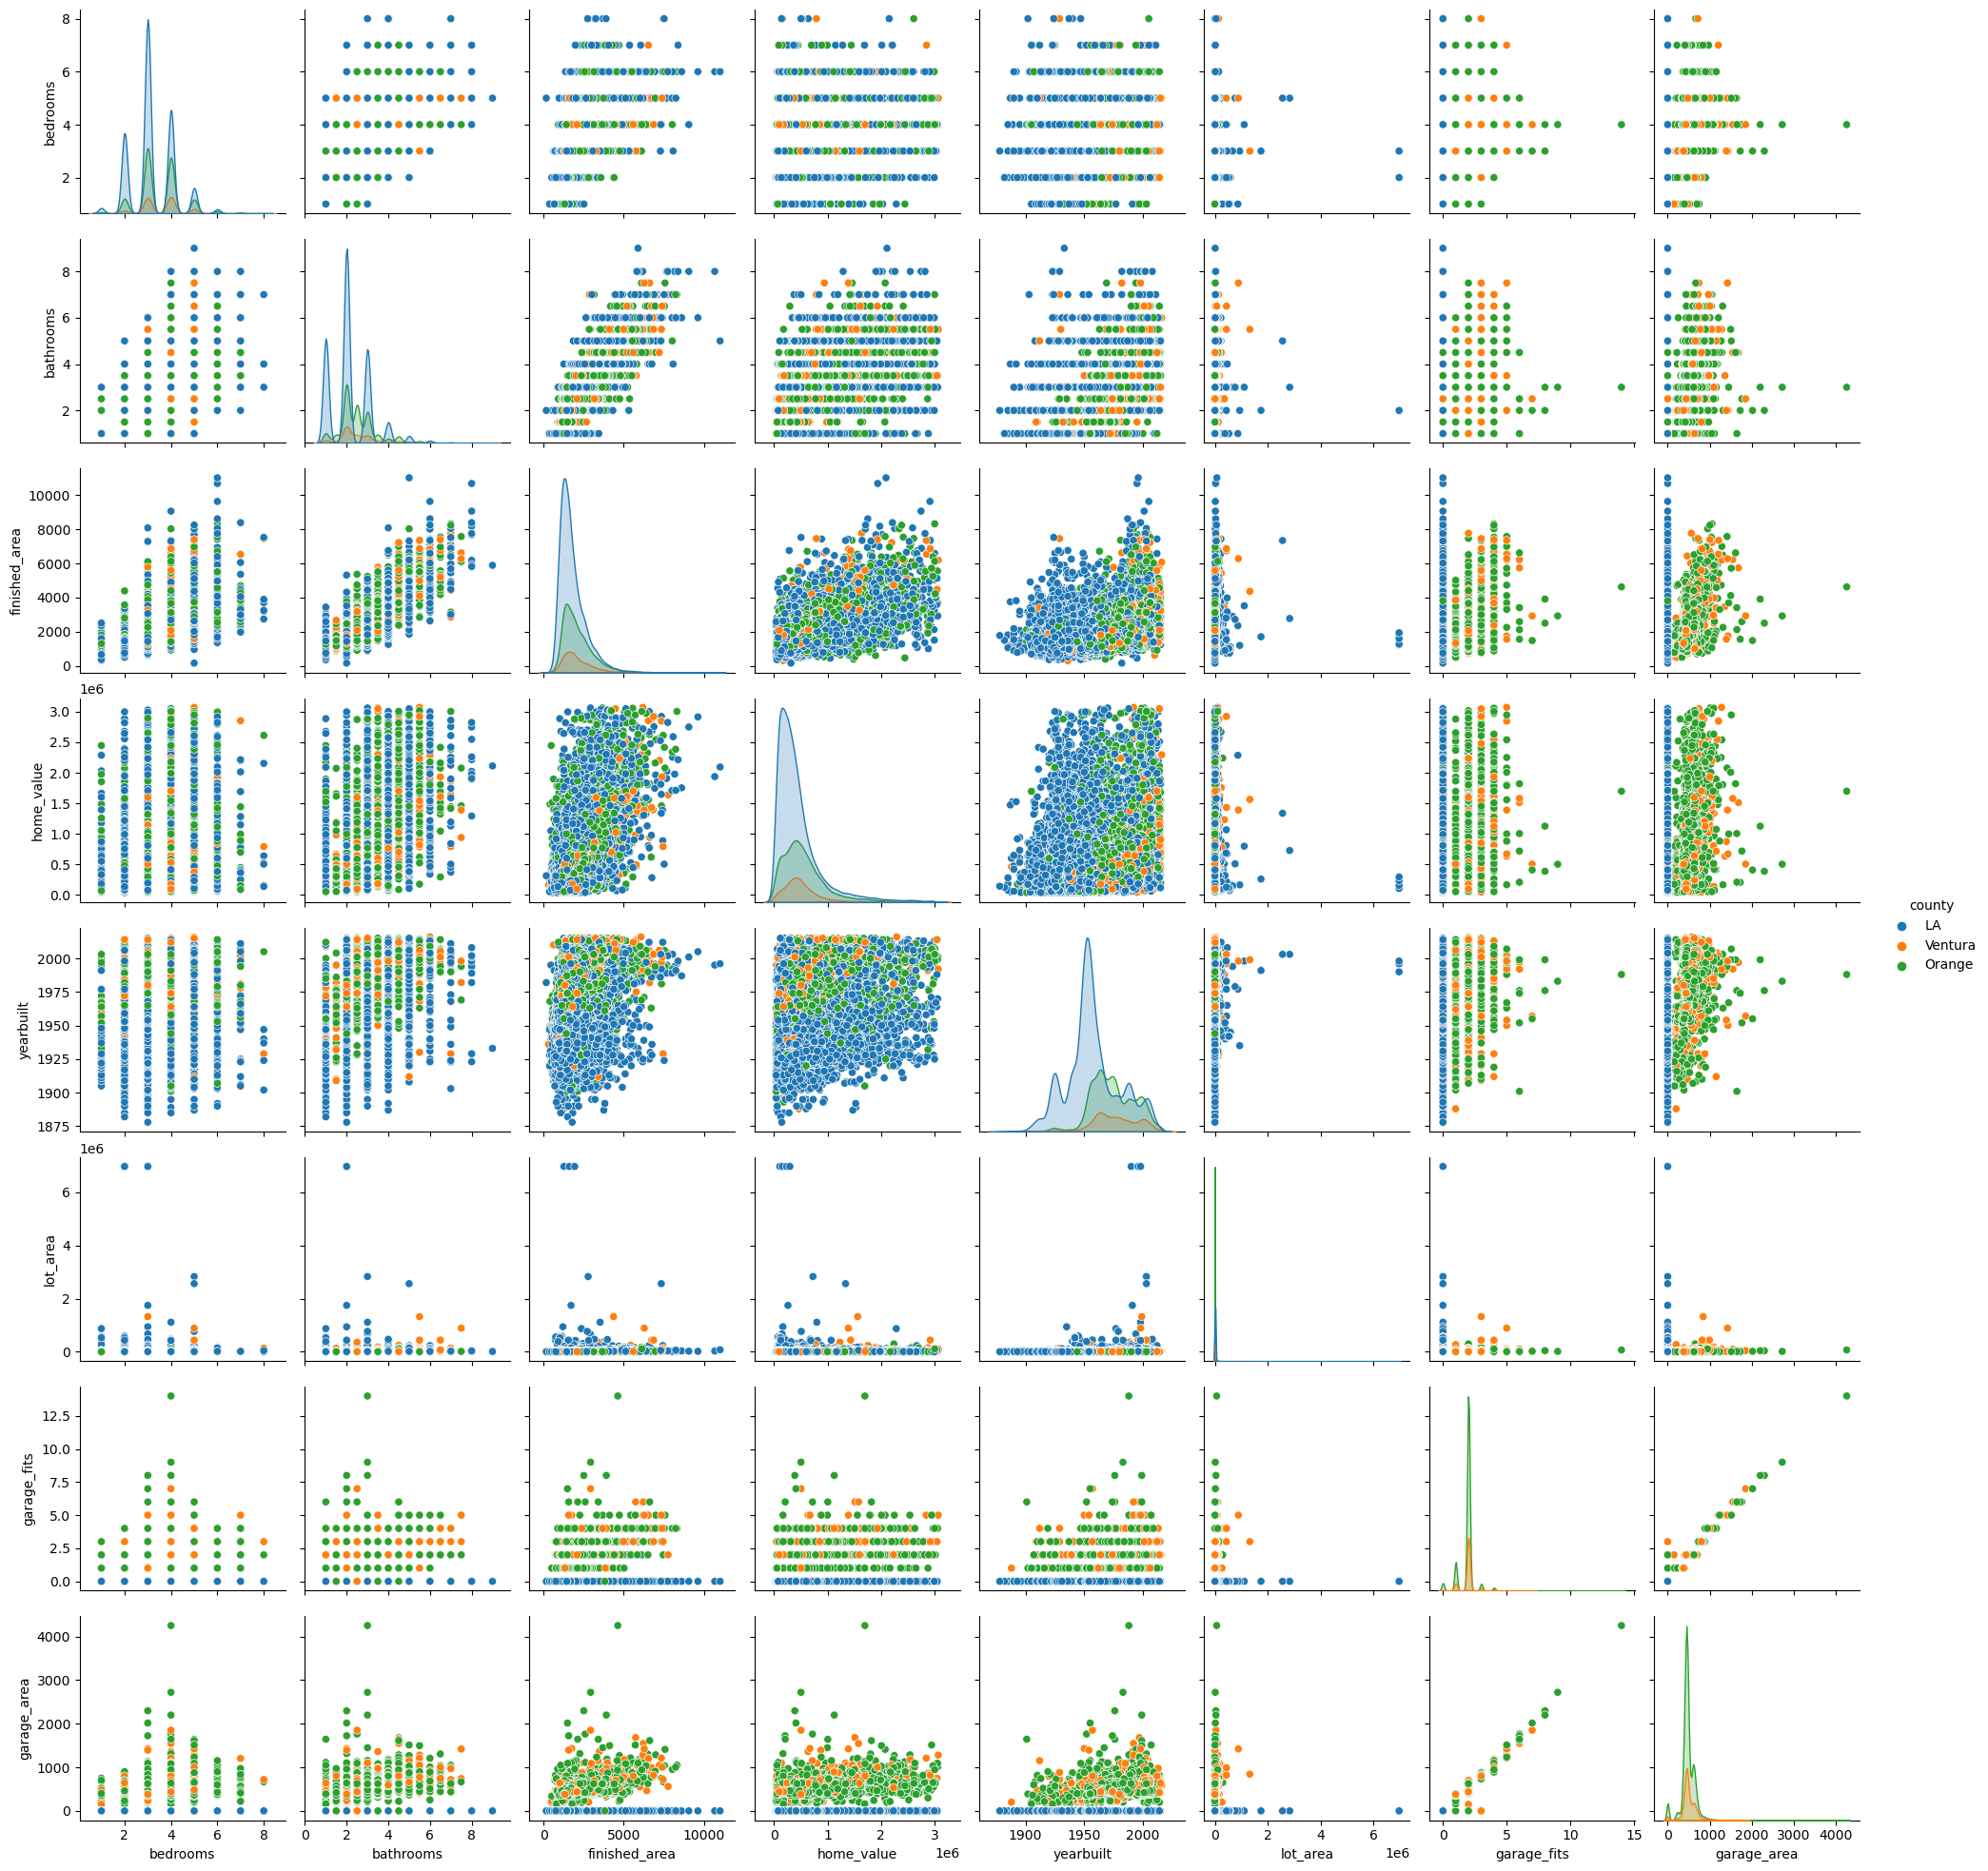

In [51]:
sns.pairplot(train, hue='county')

In [52]:
home_bed = pd.crosstab(df.bedrooms, df.home_value.sample(10000)).T

<Axes: xlabel='home_value'>

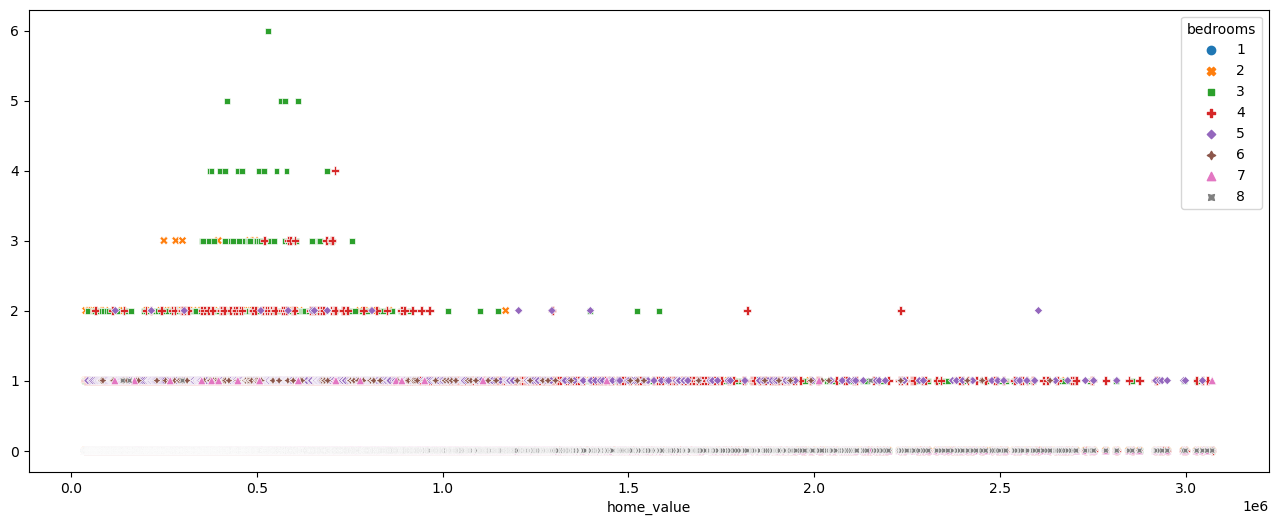

In [53]:
plt.figure(figsize=(16,6))
sns.scatterplot(home_bed)

# Does having a garage change the price?

### No garage data for LA county

In [54]:
pd.crosstab(train.county, train.garage_fits)

garage_fits,0,1,2,3,4,5,6,7,8,9,14
county,,,,,,,,,,,
LA,18270,0,0,0,0,0,0,0,0,0,0
Orange,244,908,6294,221,96,11,5,1,2,1,1
Ventura,29,271,1959,106,41,7,2,1,0,0,0


Possible to make 3 separate models based on county?

In [55]:
train_noLA = train[train['county'] != 'LA']

In [56]:
train_noLA.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
2836,5,4.5,2960.0,490568.0,2003,4500.0,Ventura,2,426.0
5265,4,2.0,2200.0,567000.0,1964,8280.0,Orange,2,465.0
39645,4,2.0,1410.0,612528.0,1967,5940.0,Orange,2,456.0
32756,3,2.0,1802.0,151888.0,1962,8000.0,Orange,2,427.0
41558,4,3.0,2490.0,780666.0,1977,8027.0,Ventura,2,645.0


In [57]:
import matplotlib as mpl
mpl.rcParams["axes.formatter.useoffset"] = False

(0.0, 5000000.0)

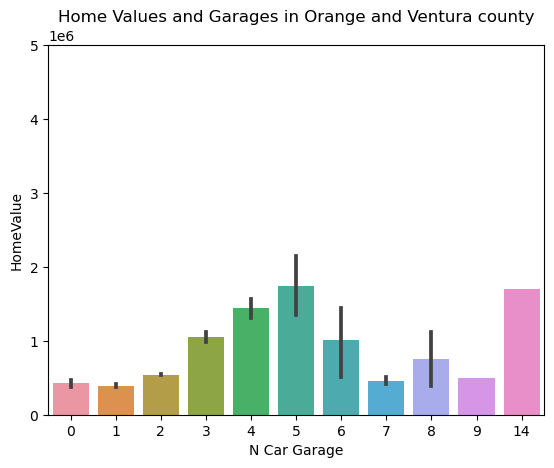

In [58]:
sns.barplot(train_noLA, x=train_noLA.garage_fits, y=train_noLA.home_value)
plt.title('Home Values and Garages in Orange and Ventura county')
plt.ylabel('HomeValue')
plt.xlabel('N Car Garage')
ax = plt.gca()

ax.set_ylim([0, 5000000])

In [59]:
def corr_heat(df, drops):
    '''Creates a heatmap off of the dataset
    
    arguments: df, 'drop items'
    
    returns: heatmap visualization'''
    sns.heatmap(df.drop(columns=drops).corr(), center=1)
    plt.title('Correlation Heatmap')

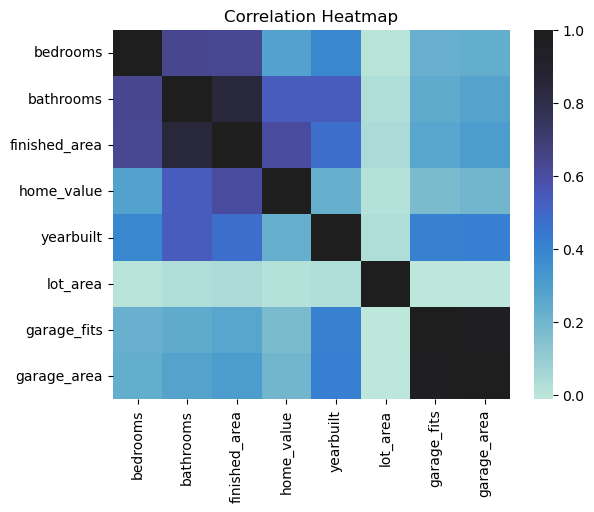

In [60]:
corr_heat(train, 'county')

So far teh best looking correlation for all counties is bedrooms, bathrooms, and finished area

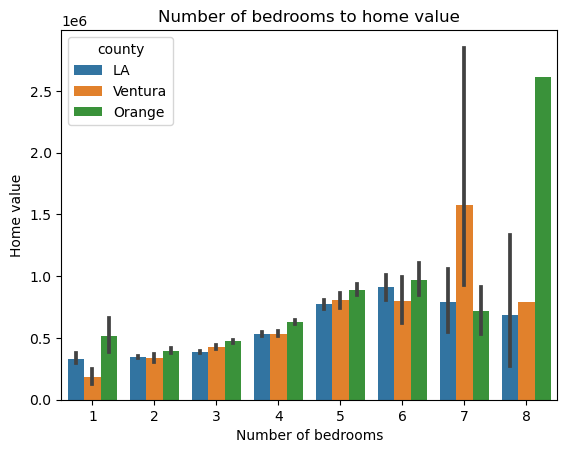

In [61]:
#plot our variables
sns.barplot(data=train, x=train.bedrooms, y=train.home_value, hue='county')
plt.title('Number of bedrooms to home value')
plt.xlabel('Number of bedrooms')
plt.ylabel('Home value')
plt.show()

<Axes: xlabel='bedrooms', ylabel='Count'>

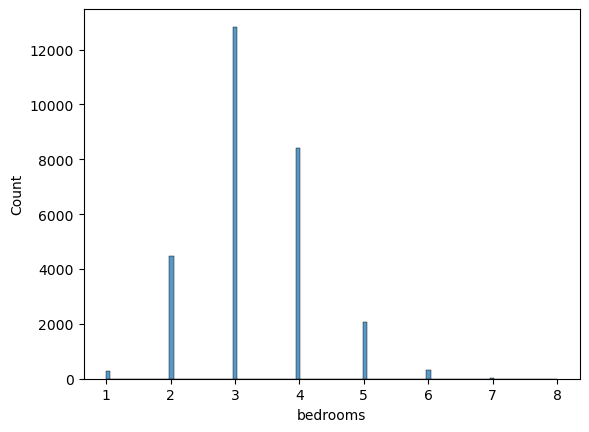

In [62]:
sns.histplot(train, x=train.bedrooms)

<Axes: title={'center': 'home_value'}, xlabel='bedrooms'>

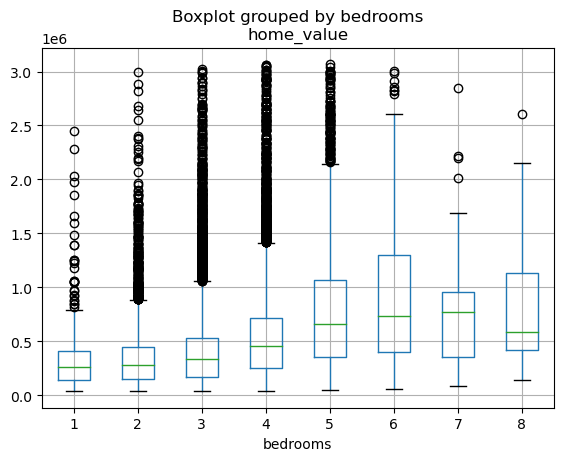

In [63]:
train.boxplot('home_value', by= 'bedrooms')

In [64]:
def catcont_four_graphs(df, var1, var2, hue):
    """ Plots 4 graphs for visual representation of 1 continuous and 1 categorical variable
    
    arguments: df, var1, var2, hue, example input --> df, 'bedrooms', 'home_value', 'county'
    
    returns: 1 bar chart, 2 histograms, 1 boxplot"""
    plt.figure(figsize=(20,10))
    plt.suptitle(f'{var1} & {var2}')
    plt.subplot(221)
    sns.barplot(data=df, x=df[var1], y=df[var2], hue=hue)
    plt.title(f'Number of {var1} to {var2}')
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(222)
    sns.histplot(df, x=df[var1], bins=20)
    plt.title(f'Count of {var1}')
    plt.xlabel(f'Number of {var1}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(223)
    sns.histplot(df, x=df[var2], bins=20)
    plt.title(f'Count of {var2}')
    plt.xlabel(f'Number of {var2}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(224)
    sns.boxplot(data=df, x=var1, y=var2, hue=hue)
    plt.grid(False)
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    plt.show()
    # print('~~~~~~~~~~~~~~~~~~~~~')

## Bedrooms & Home Value

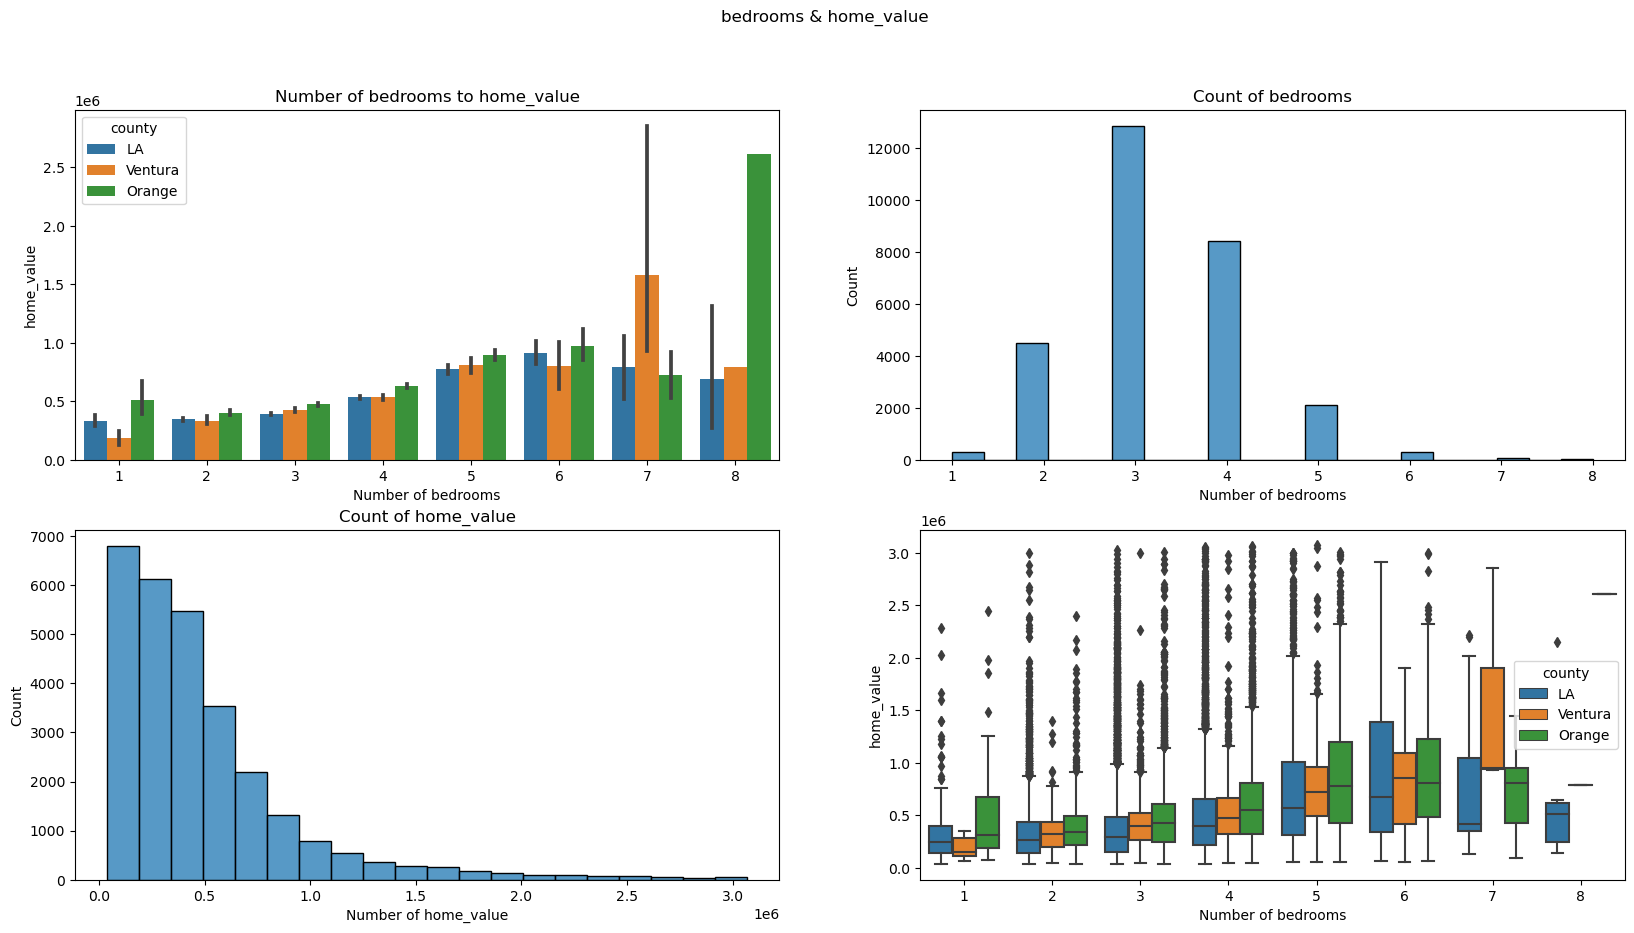

In [65]:
catcont_four_graphs(train, 'bedrooms', 'home_value', 'county')

Consider dropping bathrooms > 6 and houses with no bathroom

### Stats Test

In [66]:
# Bedrooms Normal Dist
# Home Value Skewed Right
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(train.bedrooms, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.278, p=0.000
Probably dependent


In [67]:
# Garage Skewed Right
# Home Value Skewed Right

# t-test
from scipy.stats import ttest_ind

stat, p = ttest_ind(train.bedrooms, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

stat=-186.922, p=0.000
Probably different distributions


## Bathrooms & Home Value

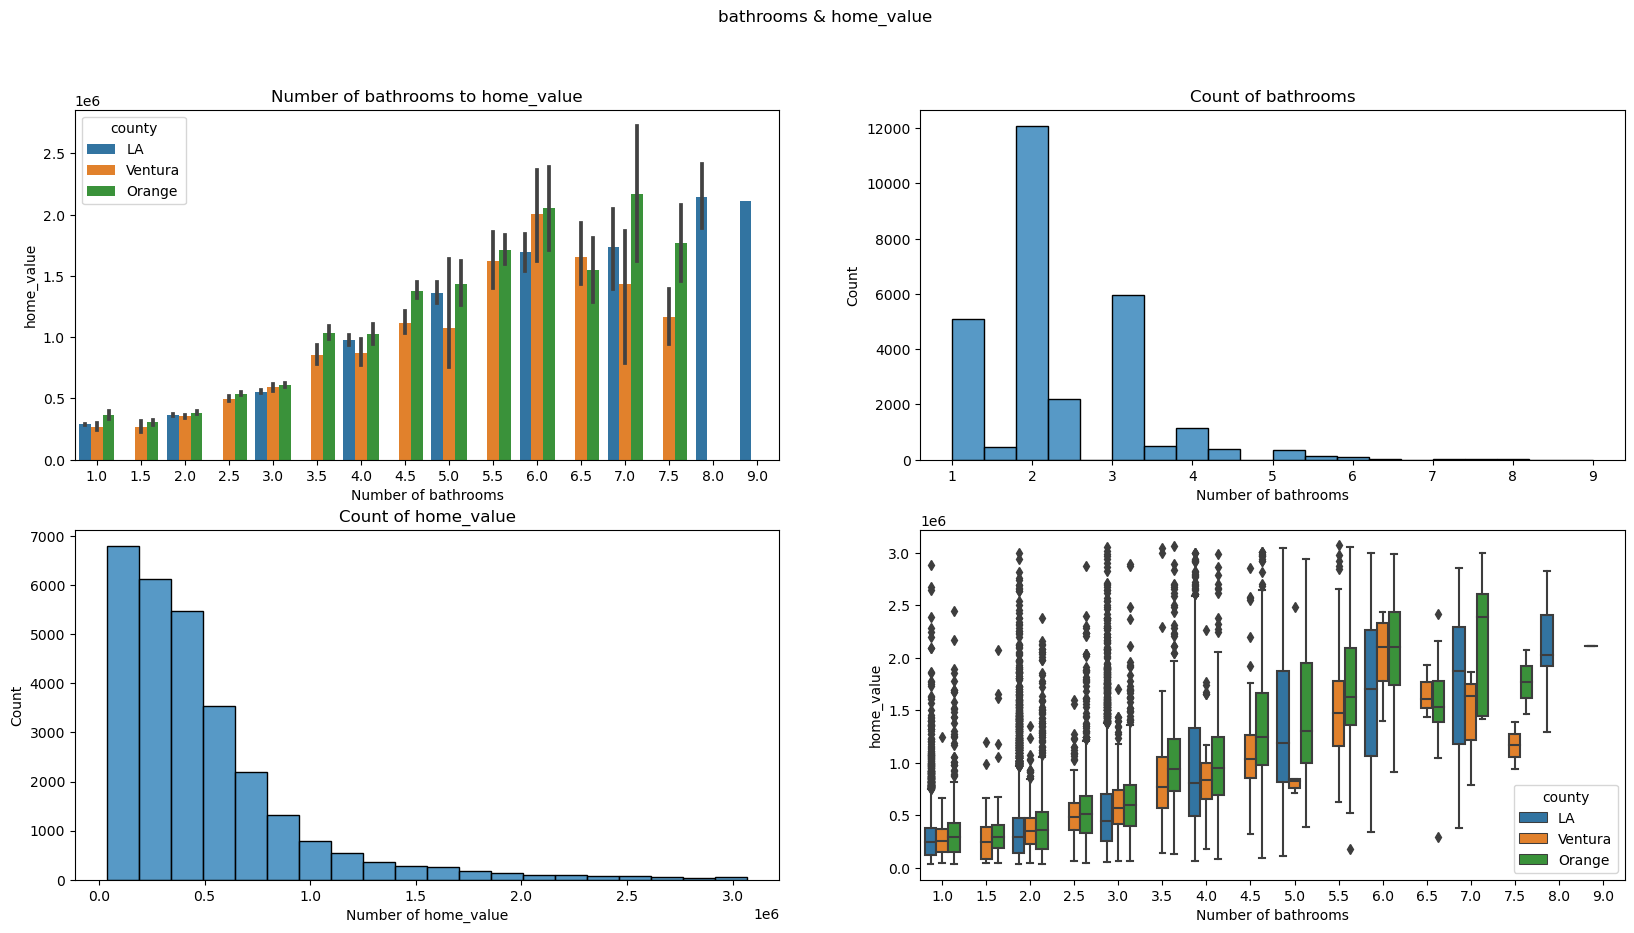

In [68]:
catcont_four_graphs(train, 'bathrooms', 'home_value', 'county')

In [69]:
# Bathrooms Normalish Dist
# Home Value Skewed Right
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(train.bathrooms, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.464, p=0.000
Probably dependent


In [70]:
# Garage Skewed Right
# Home Value Skewed Right

# t-test
from scipy.stats import ttest_ind

stat, p = ttest_ind(train.bathrooms, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

stat=-186.923, p=0.000
Probably different distributions


## Garage & Home Value

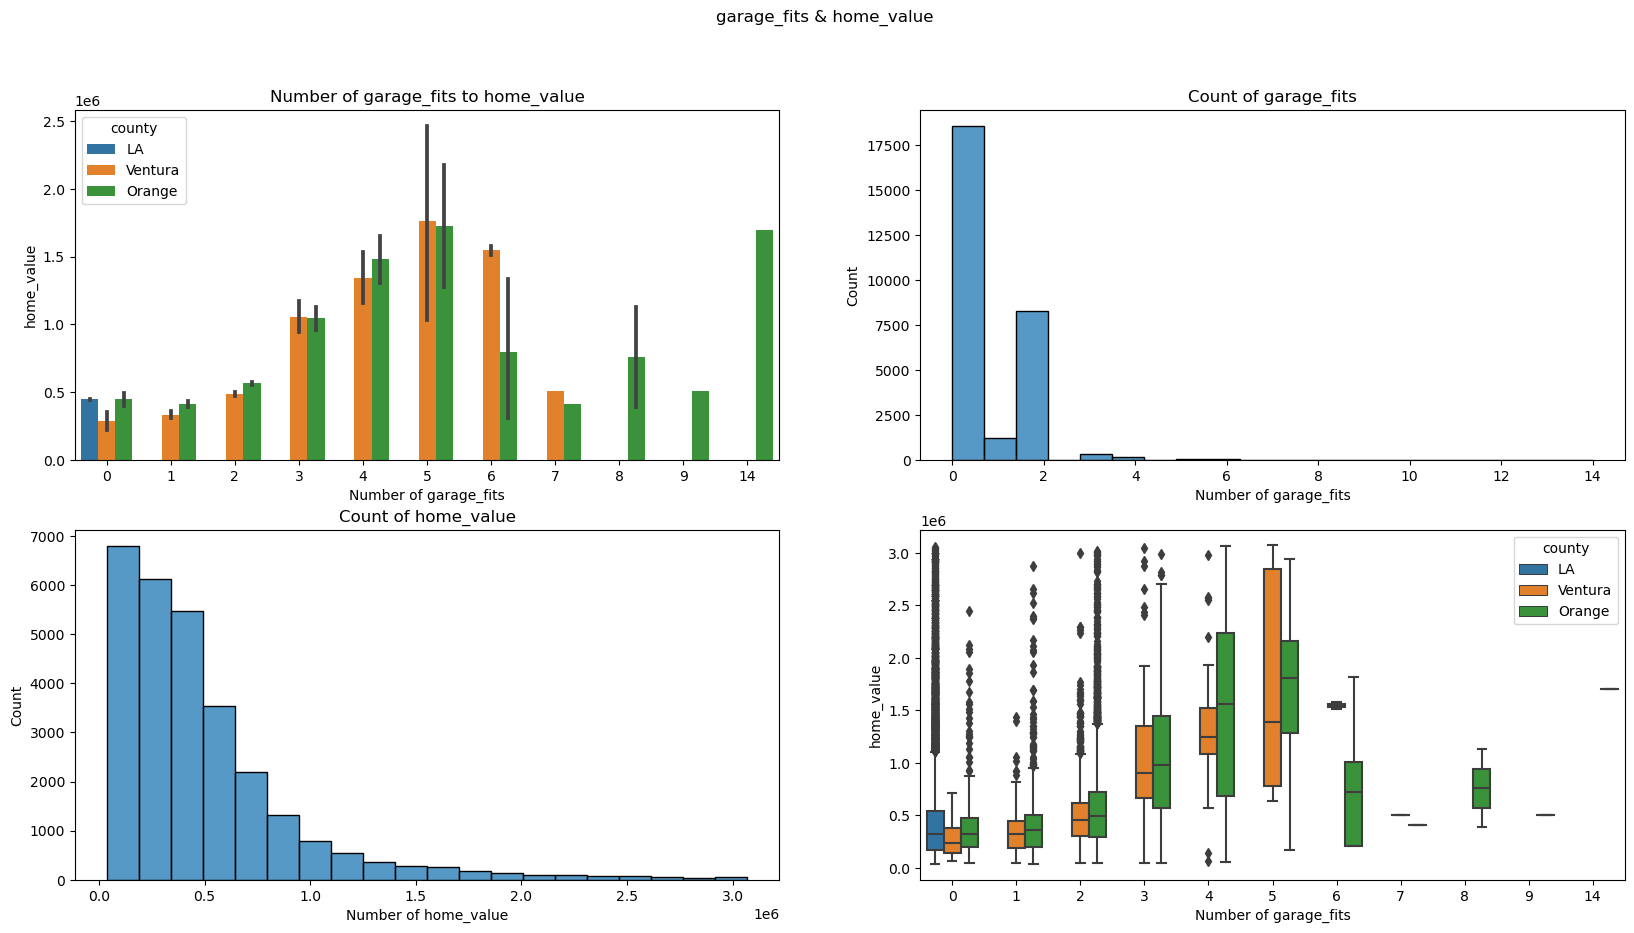

In [71]:
catcont_four_graphs(train, 'garage_fits', 'home_value', 'county')

In [72]:
# Garage Skewed Right
# Home Value Skewed Right
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(train.garage_fits, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.212, p=0.000
Probably dependent


In [73]:
# Garage Skewed Right
# Home Value Skewed Right
# Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(train.garage_fits, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.212, p=0.000
Probably dependent


In [74]:
# Garage Skewed Right
# Home Value Skewed Right

# t-test
from scipy.stats import ttest_ind

stat, p = ttest_ind(train.garage_fits, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

stat=-186.923, p=0.000
Probably different distributions


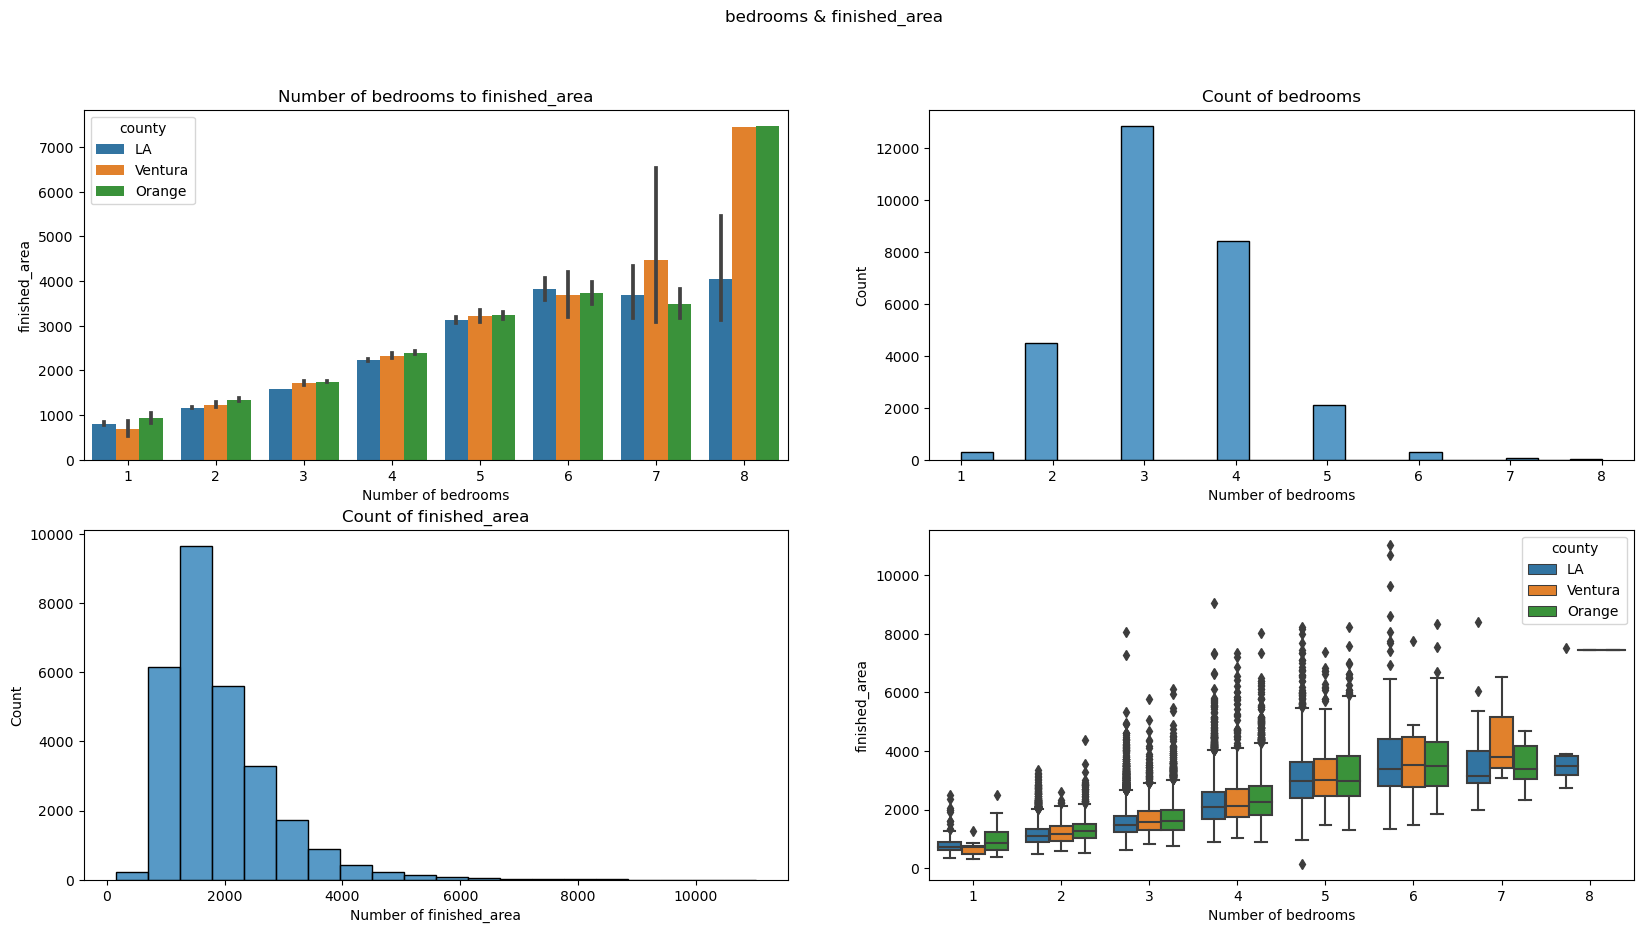

In [75]:
catcont_four_graphs(train, 'bedrooms', 'finished_area', 'county')

In [76]:
def contcont_two_graphs(df, var1, var2, hue):
    """ Plots 4 graphs for visual representation of 1 continuous and 1 categorical variable
    
    arguments: df, var1, var2, hue, example input --> df, 'bedrooms', 'home_value', 'county'
    
    returns: 1 bar chart, 2 histograms, 1 boxplot"""
    plt.figure(figsize=(20,10))
    plt.suptitle(f'{var1} & {var2}')
    plt.subplot(221)
    sns.scatterplot(data=df, x=df[var1], y=df[var2], hue=hue)
    plt.title(f'Number of {var1} to {var2}')
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(222)
    sns.histplot(df, x=df[var1], bins=20)
    plt.title(f'Count of {var1}')
    plt.xlabel(f'Number of {var1}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(223)
    sns.histplot(df, x=df[var2], bins=20)
    plt.title(f'Count of {var2}')
    plt.xlabel(f'Number of {var2}')
    
    # print('~~~~~~~~~~~~~~~~~~~~~')
    plt.subplot(224)
    sns.boxplot(data=df, x=var1, hue=hue)
    plt.grid(False)
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    plt.show()
    # print('~~~~~~~~~~~~~~~~~~~~~')

## Finished Area & Home Value

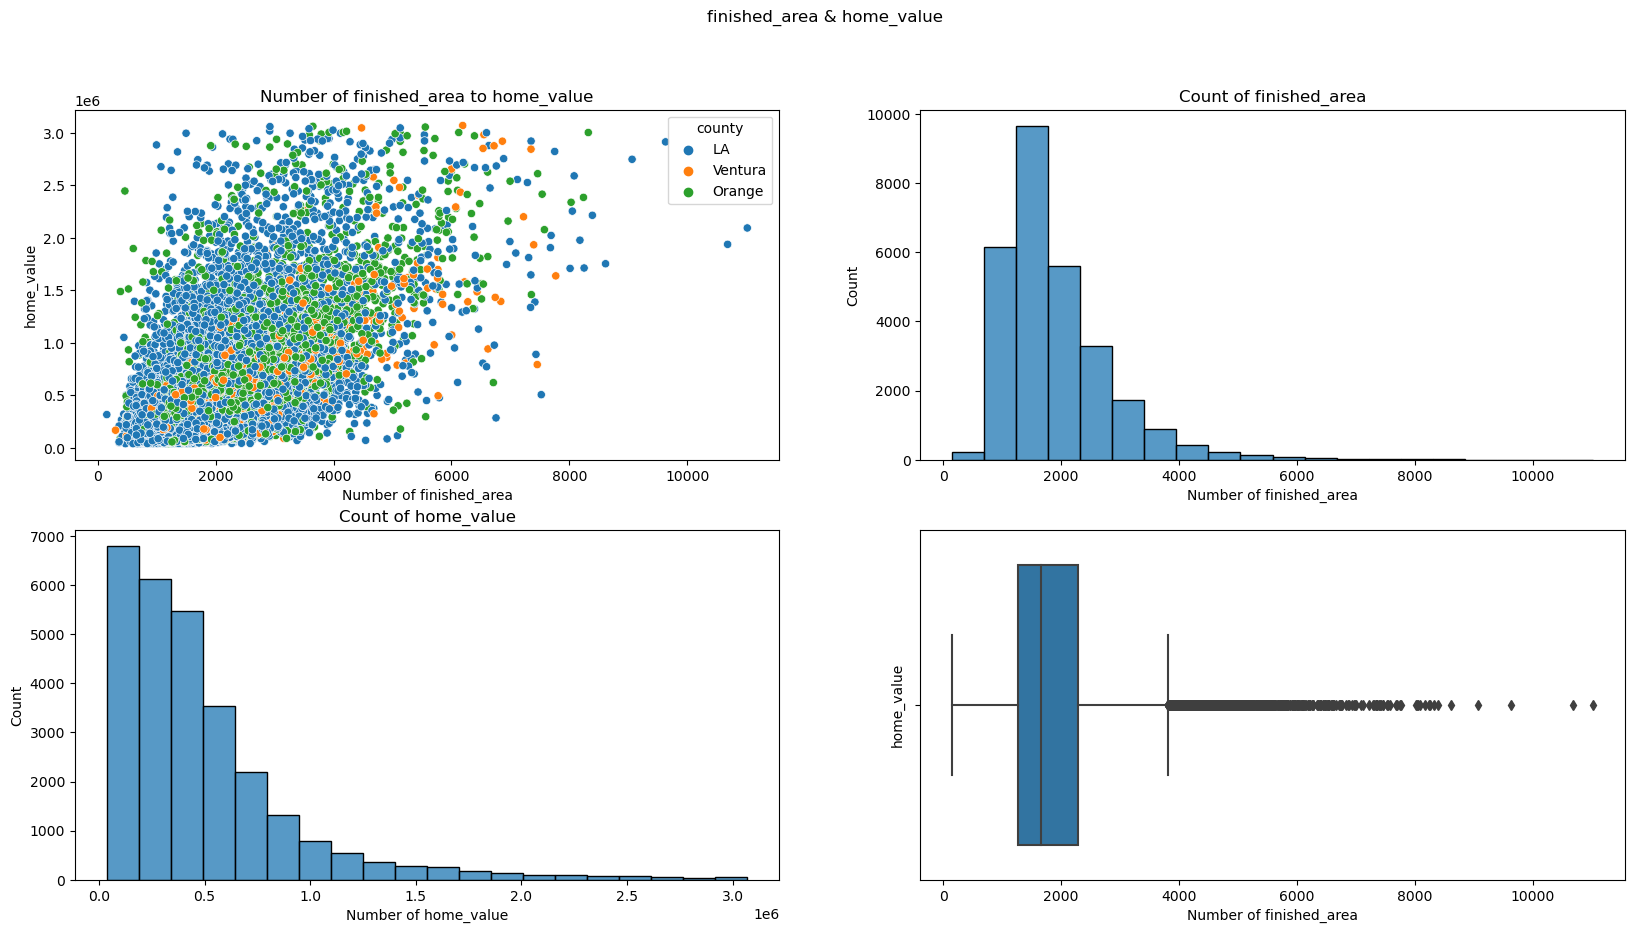

In [77]:
contcont_two_graphs(train, 'finished_area', 'home_value', 'county')

In [78]:
# create stats functions
def spear_stat(var1, var2):
    '''Takes 2 variables from a dataframe and determines if they are dependent on each other or not
    
    arguments: var1, var2
    
    returns: print statements'''
    stat, p = spearmanr(var1, var2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably independent')
    else:
        print('Probably dependent')

In [79]:
def ttest_stat(var1,var2):
    '''Takes 2 variables from a dataframe and determines if they have the same
    distribution or not.
    
    arguments: var1, var2
    
    returns: print statements'''
    # t-test
    from scipy.stats import ttest_ind

    stat, p = ttest_ind(var1, var2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

In [80]:
ttest_stat(train.finished_area, train.home_value)

stat=-186.191, p=0.000
Probably different distributions


In [81]:
# Finished area Skewed Right
# Home Value Skewed Right
# Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(train.finished_area, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.505, p=0.000
Probably dependent


In [82]:
# Finished area Skewed Right
# Home Value Skewed Right

# t-test
from scipy.stats import ttest_ind

stat, p = ttest_ind(train.finished_area, train.home_value)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

stat=-186.191, p=0.000
Probably different distributions


In [83]:
train.columns

Index(['bedrooms', 'bathrooms', 'finished_area', 'home_value', 'yearbuilt',
       'lot_area', 'county', 'garage_fits', 'garage_area'],
      dtype='object')

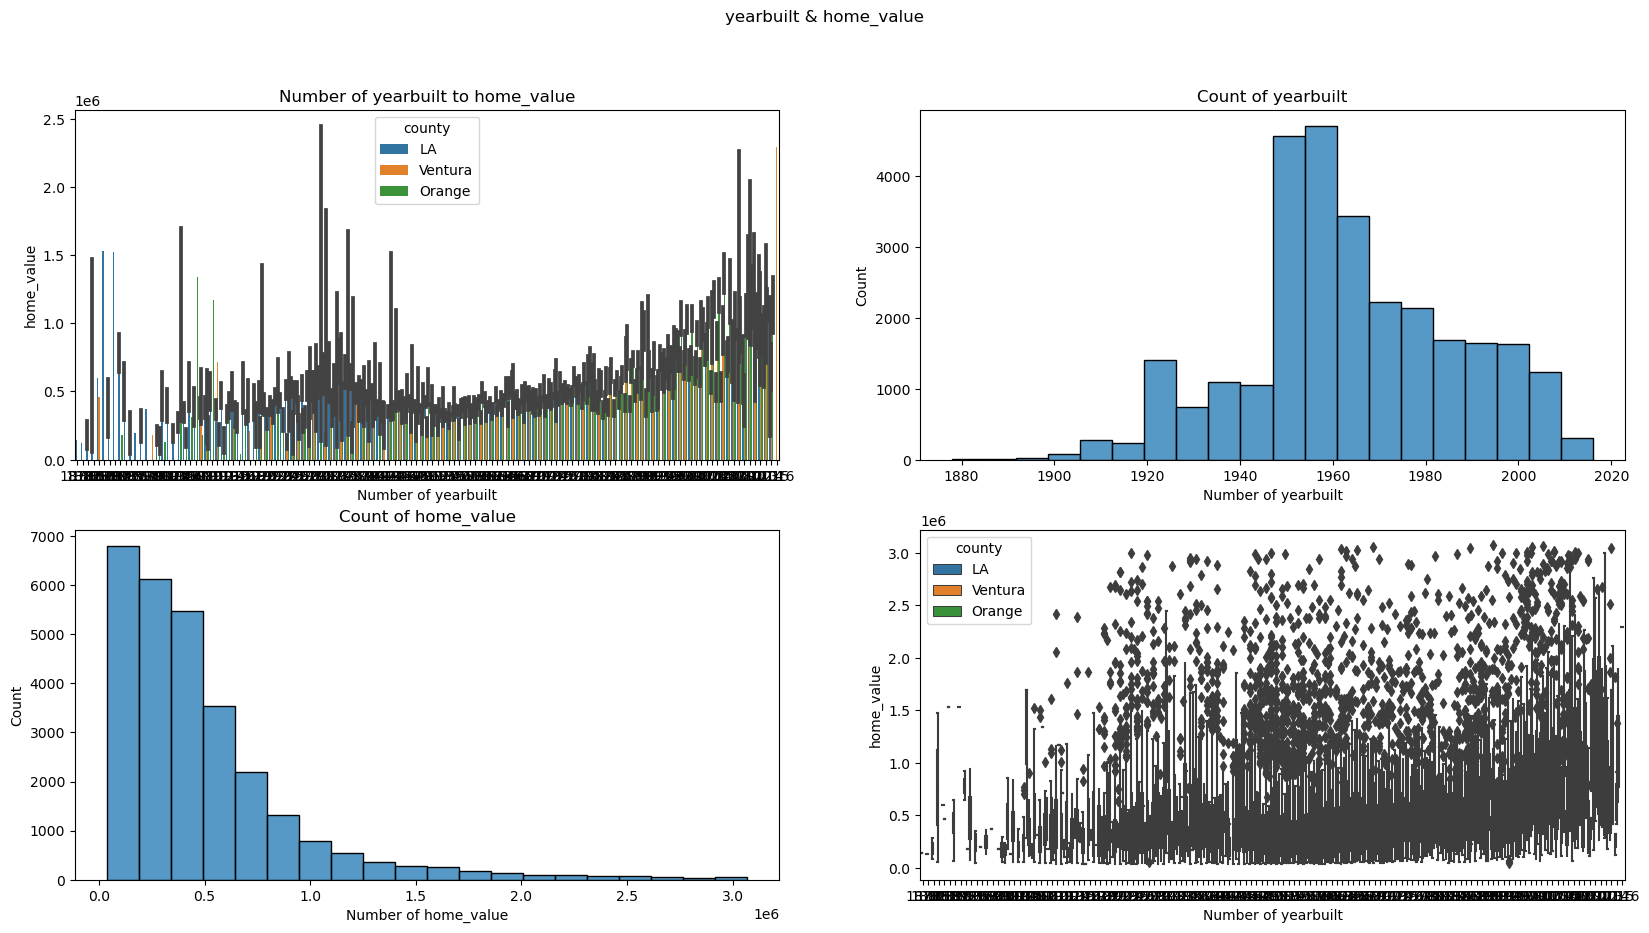

In [84]:
catcont_four_graphs(train, 'yearbuilt', 'home_value', 'county')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 28.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/cat

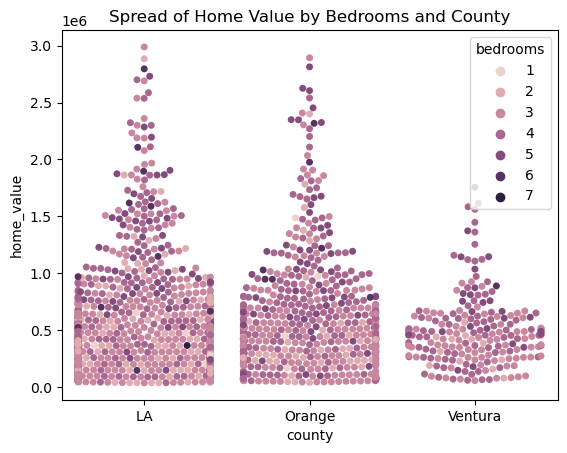

In [85]:
sns.swarmplot(
    data=train.sample(2500),
    y='home_value',
x='county',
hue='bedrooms')
plt.title('Spread of Home Value by Bedrooms and County')
plt.show()

In [86]:
import scipy.stats as stats

In [87]:
mean_home_value = train.home_value.mean()
mean_home_value

483350.5956445381

In [88]:
# cat and cont
# need mann-whitney t test for bedrooms and home_value
alpha = .05
tstat, p = stats.mannwhitneyu()

KeyError: 'x'

In [89]:
check_columns(train)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[LA, Ventura, Orange]",0,0.0,object
0,bedrooms,8,"[3, 4, 2, 5, 1, 6, 7, 8]",0,0.0,int64
7,garage_fits,11,"[0, 2, 1, 4, 3, 5, 6, 7, 8, 14, 9]",0,0.0,int64
1,bathrooms,16,"[3.0, 2.0, 4.5, 1.0, 4.0, 3.5, 2.5, 1.5, 5.0, ...",0,0.0,float64
4,yearbuilt,131,"[1956, 1964, 2014, 1991, 1954, 1949, 1969, 200...",0,0.0,int64
8,garage_area,698,"[0.0, 426.0, 465.0, 456.0, 427.0, 645.0, 651.0...",0,0.0,float64
2,finished_area,3919,"[1640.0, 1710.0, 2180.0, 2260.0, 1571.0, 1298....",0,0.0,float64
5,lot_area,10435,"[7119.0, 7811.0, 6636.0, 6749.0, 7597.0, 5518....",0,0.0,float64
3,home_value,22943,"[238697.0, 457000.0, 274015.0, 609150.0, 11557...",0,0.0,float64


## All Counties

## for bathrooms bedrooms and finished area first

Lets get ready for some modeling

In [90]:
# Make Dummies
dummy_list = ['county']
dummy_df = pd.get_dummies(train[dummy_list], dtype=int, drop_first=True)
train_prepd = pd.concat([train, dummy_df], axis=1)

In [91]:
train_prepd.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area,county_Orange,county_Ventura
9449,3,3.0,1640.0,238697.0,1956,7119.0,LA,0,0.0,0,0
28696,3,2.0,1710.0,457000.0,1964,7811.0,LA,0,0.0,0,0
11759,3,3.0,2180.0,274015.0,2014,6636.0,LA,0,0.0,0,0
25505,4,3.0,2260.0,609150.0,1991,6749.0,LA,0,0.0,0,0
31727,3,2.0,1571.0,115576.0,1954,7597.0,LA,0,0.0,0,0


In [92]:
def model_prep_zillow(train, validate, test, target):
    # Make Dummies
    dummy_list = ['county']
    dummy_df = pd.get_dummies(train[dummy_list], dtype=int, drop_first=True)
    train_prepd = pd.concat([train, dummy_df], axis=1)

    dummy_list = ['county']
    dummy_df = pd.get_dummies(validate[dummy_list], dtype=int, drop_first=True)
    validate_prepd = pd.concat([validate, dummy_df], axis=1)

    dummy_list = ['county']
    dummy_df = pd.get_dummies(test[dummy_list], dtype=int, drop_first=True)
    test_prepd = pd.concat([test, dummy_df], axis=1)

    X_train = train_prepd[['bedrooms', 'bathrooms', 'finished_area']]
    y_train = train_prepd[target]

    X_validate = validate[['bedrooms', 'bathrooms', 'finished_area']]
    y_validate = validate_prepd[target]

    X_test = test[['bedrooms', 'bathrooms', 'finished_area']]
    y_test = test_prepd[target]


    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

    

In [93]:
X_train, y_train, X_validate, y_validate, X_test, y_test = model_prep_zillow(train, validate, test, 'home_value')

In [94]:
X_train.head()

,bedrooms,bathrooms,finished_area
9449,3,3.0,1640.0
28696,3,2.0,1710.0
11759,3,3.0,2180.0
25505,4,3.0,2260.0
31727,3,2.0,1571.0


I want Unscaled

In [95]:
# X and y splits to scale
target = "home_value"

X_train = train[['bedrooms', 'bathrooms', 'finished_area']]
y_train = train[target]

X_validate = validate[['bedrooms', 'bathrooms', 'finished_area']]
y_validate = validate[target]

X_test = test[['bedrooms', 'bathrooms', 'finished_area']]
y_test = test[target]

Now Scaled

In [96]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

In [97]:
train_scaled = train.copy()
valid_scaled = validate.copy()
test_scaled = test.copy()

In [98]:
columns_to_scale = ['bedrooms', 'bathrooms', 'finished_area']

scaler = RobustScaler()

train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
valid_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [99]:
def model_prep_zillow_scaled(X_train, X_validate, X_test):
    '''Takes the X train, validate, and test and fits them to a RobustScaler
    
    arguments: X_train, X_validate, X_test
    
    returns: X_train_scaled, X_validate_scaled, X_test_scaled'''
    # makes a copy of the dataframes
    X_train_scaled = X_train.copy()
    X_valid_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()

    columns_to_scale = ['bedrooms', 'bathrooms', 'finished_area']

    scaler = RobustScaler()

    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_valid_scaled[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    return X_train_scaled, X_valid_scaled, X_test_scaled

In [100]:
X_train_scaled, X_valid_scaled, X_test_scaled = model_prep_zillow_scaled(X_train, X_validate, X_test)

In [101]:
X_train_scaled

,bedrooms,bathrooms,finished_area
9449,0.0,1.0,-0.019685
28696,0.0,0.0,0.049213
11759,0.0,1.0,0.511811
25505,1.0,1.0,0.590551
31727,0.0,0.0,-0.087598
...,...,...,...
20725,1.0,0.5,0.406496
11823,1.0,1.0,1.010827
33207,0.0,0.0,-0.334646
20150,-1.0,-1.0,-0.204724


In [102]:
train.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
9449,3,3.0,1640.0,238697.0,1956,7119.0,LA,0,0.0
28696,3,2.0,1710.0,457000.0,1964,7811.0,LA,0,0.0
11759,3,3.0,2180.0,274015.0,2014,6636.0,LA,0,0.0
25505,4,3.0,2260.0,609150.0,1991,6749.0,LA,0,0.0
31727,3,2.0,1571.0,115576.0,1954,7597.0,LA,0,0.0


In [103]:
train_scaled.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
9449,0.0,1.0,-0.019685,238697.0,1956,7119.0,LA,0,0.0
28696,0.0,0.0,0.049213,457000.0,1964,7811.0,LA,0,0.0
11759,0.0,1.0,0.511811,274015.0,2014,6636.0,LA,0,0.0
25505,1.0,1.0,0.590551,609150.0,1991,6749.0,LA,0,0.0
31727,0.0,0.0,-0.087598,115576.0,1954,7597.0,LA,0,0.0


In [104]:
valid_scaled.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
34564,0.0,1.0,0.807087,827374.0,1952,7565.0,LA,0,0.0
11896,1.0,0.0,-0.088583,271955.0,1947,5474.0,LA,0,0.0
13564,0.0,0.0,-0.511811,190372.0,1959,6901.0,LA,0,0.0
47286,1.0,0.0,0.163386,391834.0,1970,6555.0,Ventura,2,441.0
46304,0.0,0.0,-0.141732,355396.0,1952,5000.0,LA,0,0.0


In [105]:

X_train_scaled = train_scaled[['bedrooms', 'bathrooms', 'finished_area']]

X_validate_scaled = valid_scaled[['bedrooms', 'bathrooms', 'finished_area']]

X_test_scaled = test_scaled[['bedrooms', 'bathrooms', 'finished_area']]


In [106]:
X_train.head()

,bedrooms,bathrooms,finished_area
9449,3,3.0,1640.0
28696,3,2.0,1710.0
11759,3,3.0,2180.0
25505,4,3.0,2260.0
31727,3,2.0,1571.0


In [107]:
X_train_scaled.head()

,bedrooms,bathrooms,finished_area
9449,0.0,1.0,-0.019685
28696,0.0,0.0,0.049213
11759,0.0,1.0,0.511811
25505,1.0,1.0,0.590551
31727,0.0,0.0,-0.087598


### Modeling

Start with 'bedrooms', 'bathrooms', and 'finished_area'

In [108]:
X_train.head()

,bedrooms,bathrooms,finished_area
9449,3,3.0,1640.0
28696,3,2.0,1710.0
11759,3,3.0,2180.0
25505,4,3.0,2260.0
31727,3,2.0,1571.0


In [109]:
X_train_scaled.head()

,bedrooms,bathrooms,finished_area
9449,0.0,1.0,-0.019685
28696,0.0,0.0,0.049213
11759,0.0,1.0,0.511811
25505,1.0,1.0,0.590551
31727,0.0,0.0,-0.087598


### Baseline

In [110]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [111]:
baseline = y_train.mean()
baseline

483350.5956445381

In [112]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [113]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([483350.59564454, 483350.59564454, 483350.59564454, 483350.59564454,
       483350.59564454])

In [114]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(436299.2747071282, 0.0)

In [115]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.0


In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

### Which feature is the best out of the 3?

In [121]:

#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train_scaled, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train_scaled)

#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)

In [118]:
def get_best_feat_rfe(df,df2, y, n):


    #intial ML model
    lr1 = LinearRegression()

    #make it
    rfe = RFE(lr1, n_features_to_select=n)

    #fit it
    rfe.fit(df, y)

    #use it on train
    X_train_rfe = rfe.transform(df)

    #use it on validate
    X_val_rfe = rfe.transform(df2)
    print('selected top feature:', rfe.get_feature_names_out())
    return X_train_rfe, X_val_rfe

In [122]:
X_train_rfe, X_val_rfe = get_best_feat_rfe(X_train_scaled, X_valid_scaled, y_train, 1)

selected top feature: ['finished_area']


In [123]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['finished_area']


### I still want to use all 3 though

### All models Regression Models used Scaled data

### Multiple Regression

In [124]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=3)

#fit it
rfe.fit(X_train_scaled, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train_scaled)

#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)

In [125]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bedrooms' 'bathrooms' 'finished_area']


In [126]:
def get_lr(df, df2, y, y2, n):
    #intial ML model
    lr1 = LinearRegression()

    #make it
    rfe = RFE(lr1, n_features_to_select=n)

    #fit it
    rfe.fit(df, y)

    #use it on train
    X_train_rfe = rfe.transform(df)

    #use it on validate
    X_val_rfe = rfe.transform(df2)

    print('selected top feature:', rfe.get_feature_names_out())

    lr1.fit(X_train_rfe, y)

    #use the thing (make predictions)
    pred_lr1 = lr1.predict(X_train_rfe)
    pred_val_lr1 = lr1.predict(X_val_rfe)

    #train
    metrics_reg(y, pred_lr1)

    #validate
    rmse, r2 = metrics_reg(y2, pred_val_lr1)


    return rmse, r2

In [127]:
rmse, r2 = get_lr(X_train_scaled, X_valid_scaled, y_train, y_validate, 3)
rmse, r2

selected top feature: ['bedrooms' 'bathrooms' 'finished_area']


(338239.85815456643, 0.3764368451033524)

In [128]:
def get_lr(df, df2, y, y2):
    #fit the thing
    lr1.fit(df, y)

    #use the thing (make predictions)
    pred_lr1 = lr1.predict(df)
    pred_val_lr1 = lr1.predict(df2)

    #train
    metrics_reg(y, pred_lr1)

    #validate
    rmse, r2 = metrics_reg(y2, pred_val_lr1)


    return rmse, r2

In [129]:
rmse, r2 = get_lr(X_train_rfe, X_val_rfe, y_train, y_validate)
rmse, r2

(338239.85815456643, 0.3764368451033524)

In [130]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [131]:
pred_lr1[:10]

array([488004.95004703, 438723.04489728, 646188.38777526, 576205.02815888,
       398005.45629686, 411452.88354   , 591730.43963961, 792520.43803188,
       260496.01484229, 282297.20092158])

In [132]:
#train
metrics_reg(y_train, pred_lr1)

(340057.1931194482, 0.39251585232548003)

In [133]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(338239.85815456643, 0.3764368451033524)

In [134]:
#add to my metrics df
metrics_df.loc[1] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,ols,338239.858155,0.376437


In [135]:
lr1.intercept_ 

424076.4302928114

In [136]:
lr1.coef_

array([-93417.94298353,  69787.165596  , 297619.20876275])

In [137]:
print(f'home_value = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*bedrooms + {lr1.coef_[1]:.2}*bathrooms + {lr1.coef_[2]:.2}*finished_area')

home_value = 4.24e+05 + -9.3e+04*bedrooms + 7e+04*bathrooms + 3e+05*finished_area


### LassoLars

In [138]:
#import
from sklearn.linear_model import LassoLars

In [139]:
def get_lasso(df, df2, y, y2):
    #make it
    lars = LassoLars(alpha=1)

    #fit it
    lars.fit(df, y)

    #use it
    pred_lars = lars.predict(df)
    pred_val_lars = lars.predict(df2)

    #train
    metrics_reg(y, pred_lars)

    #validate
    rmse, r2 = metrics_reg(y2, pred_val_lars)
    
    return rmse, r2



In [140]:
rmse, r2 = get_lasso(X_train_scaled, X_valid_scaled, y_train, y_validate)
rmse, r2

(338239.8374247037, 0.3764369215365573)

In [141]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train_scaled, y_train)

#use it
pred_lars = lars.predict(X_train_scaled)
pred_val_lars = lars.predict(X_validate_scaled)

In [142]:
#train
metrics_reg(y_train, pred_lars)

(340057.1931303952, 0.3925158522863682)

In [143]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(338239.8374247037, 0.3764369215365573)

In [144]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,ols,338239.858155,0.376437
3,lars,338239.837425,0.376437


### Polynomial Regression

Poly 2

In [145]:
#import
from sklearn.preprocessing import PolynomialFeatures

In [146]:
def get_poly(df,df2,y,y2,n):
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=n)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(df)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(df2)
    

    #make it
    pr = LinearRegression()

    #fit it
    pr.fit(X_train_degree2, y)

    #use it
    pred_pr = pr.predict(X_train_degree2)
    pred_val_pr = pr.predict(X_validate_degree2)

    #train
    metrics_reg(y, pred_pr)
    #validate
    rmse, r2 = metrics_reg(y2, pred_val_pr)
    return rmse, r2

In [147]:
rmse, r2 = get_poly(X_train_scaled, X_validate_scaled, y_train,y_validate, 2)
rmse, r2

(335612.3315603228, 0.38608718573431466)

In [148]:
rmse, r2 = get_poly(X_train_scaled, X_validate_scaled, y_train,y_validate, 3)
rmse, r2

(335040.36504114565, 0.38817792156117237)

In [149]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [150]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [151]:
#train
metrics_reg(y_train, pred_pr)

(337688.9593279252, 0.4009476980614296)

In [152]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(335612.3315603228, 0.38608718573431466)

In [153]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,ols,338239.858155,0.376437
3,lars,338239.837425,0.376437
4,poly_2,335612.331560,0.386087


Poly 3

In [154]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [155]:
#make it
pr2 = LinearRegression()

#fit it
pr2.fit(X_train_degree3, y_train)

#use it
pred_pr2 = pr2.predict(X_train_degree3)
pred_val_pr2 = pr2.predict(X_validate_degree3)

In [156]:
#train
metrics_reg(y_train, pred_pr2)

(335390.49188409455, 0.40907479998877505)

In [157]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr2)
rmse, r2

(335040.36504114565, 0.38817792156117237)

In [158]:
#add to my metrics df
metrics_df.loc[5] = ['poly_3', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,ols,338239.858155,0.376437
3,lars,338239.837425,0.376437
4,poly_2,335612.331560,0.386087
5,poly_3,335040.365041,0.388178


In [208]:
def act_poly3_hist(y_train, pred_pr):
    plt.hist(y_train, color='blue', alpha=.5, label="Actual")
    # plt.hist(pred_lr1, color='red', alpha=.5, label="LinearRegression")
    # plt.hist(pred_lars, color='yellow', alpha=.5, label="LassoLars")
    # plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")
    plt.hist(pred_pr, color='pink', alpha=.5, label="Polynomial 3Deg")

    plt.xlabel("Home Value")
    plt.ylabel("Number of Houses")
    plt.title("Comparing the Distribution of Actual to Predicted House Values")
    plt.legend()
    plt.show()

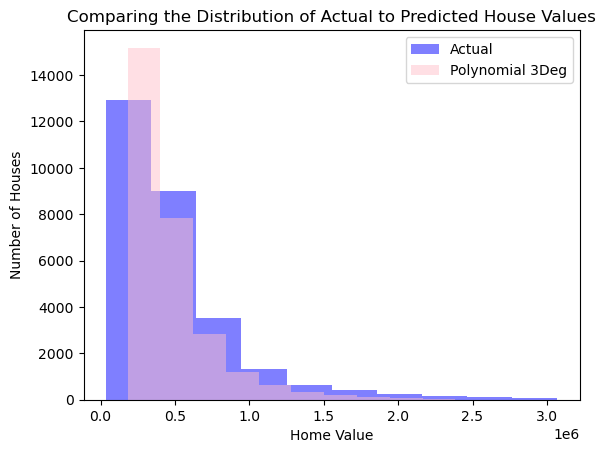

In [197]:
act_poly3_hist()

In [206]:
def act_ploy2_hist(y_train, pred_pr):

    plt.hist(y_train, color='blue', alpha=.5, label="Actual")
    # plt.hist(pred_lr1, color='red', alpha=.5, label="LinearRegression")
    # plt.hist(pred_lars, color='yellow', alpha=.5, label="LassoLars")
    plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")
    # plt.hist(pred_pr2, color='pink', alpha=.5, label="Polynomial 3Deg")

    plt.xlabel("Home Value")
    plt.ylabel("Number of Houses")
    plt.title("Comparing the Distribution of Actual to Predicted House Values")
    plt.legend()
    plt.show()

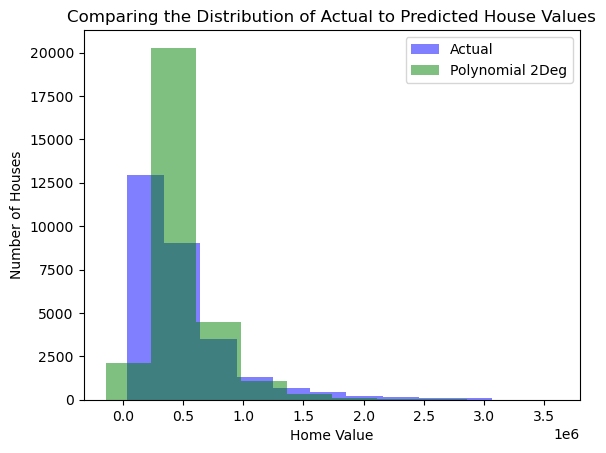

In [207]:
act_ploy2_hist(y_train, pred_pr)

In [203]:
def act_lr_lar_hist(y_train, pred_lr1, pred_lars):
    plt.hist(y_train, color='blue', alpha=.5, label="Actual")
    plt.hist(pred_lr1, color='red', alpha=.5, label="LinearRegression")
    plt.hist(pred_lars, color='gray', alpha=.5, label="LassoLars")
    # plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")
    # plt.hist(pred_pr2, color='pink', alpha=.5, label="Polynomial 3Deg")

    plt.xlabel("Home Value")
    plt.ylabel("Number of Houses")
    plt.title("Comparing the Distribution of Actual to Predicted House Values")
    plt.legend()
    plt.show()

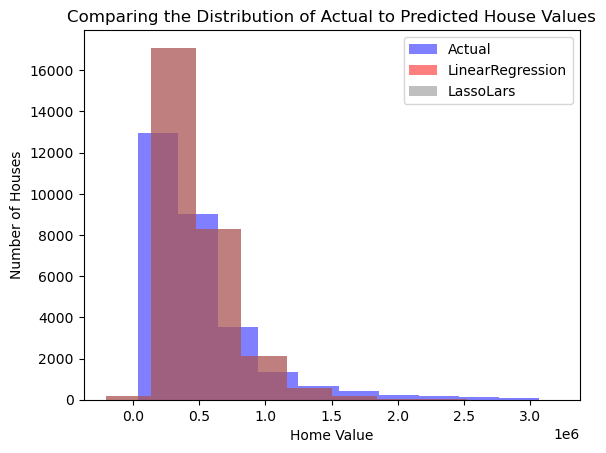

In [204]:
act_lr_lar_hist(y_train, pred_lr1, pred_lars)

In [162]:
train.columns

Index(['bedrooms', 'bathrooms', 'finished_area', 'home_value', 'yearbuilt',
       'lot_area', 'county', 'garage_fits', 'garage_area'],
      dtype='object')

In [181]:
df = get_zillow()

In [182]:
df = w.prep_zillow(df)

In [183]:
train, validate, test = w.split_data(df)

Train: 0.5599811176019355
Validate: 0.2400031470663441
Test: 0.20001573533172046


In [191]:
train.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
9449,3,3.0,1640.0,238697.0,1956,7119.0,LA,0,0.0
28696,3,2.0,1710.0,457000.0,1964,7811.0,LA,0,0.0
11759,3,3.0,2180.0,274015.0,2014,6636.0,LA,0,0.0
25505,4,3.0,2260.0,609150.0,1991,6749.0,LA,0,0.0
31727,3,2.0,1571.0,115576.0,1954,7597.0,LA,0,0.0


In [194]:
def model_prep_zillow_all_feats(train, validate, test, target):
    # Make Dummies
    dummy_list = ['county']
    dummy_df = pd.get_dummies(train[dummy_list], dtype=int, drop_first=True)
    train_prepd = pd.concat([train, dummy_df], axis=1)

    dummy_list = ['county']
    dummy_df = pd.get_dummies(validate[dummy_list], dtype=int, drop_first=True)
    validate_prepd = pd.concat([validate, dummy_df], axis=1)

    dummy_list = ['county']
    dummy_df = pd.get_dummies(test[dummy_list], dtype=int, drop_first=True)
    test_prepd = pd.concat([test, dummy_df], axis=1)

    X_train_all = train_prepd[['bedrooms', 'bathrooms', 'finished_area', 'garage_fits', 'garage_area', 'yearbuilt', 'county_Orange', 'county_Ventura']]
    y_train_all = train_prepd[target]

    X_validate_all = validate[['bedrooms', 'bathrooms', 'finished_area', 'garage_fits', 'garage_area', 'yearbuilt', 'county_Orange', 'county_Ventura']]
    y_validate_all = validate_prepd[target]

    X_test_all = test[['bedrooms', 'bathrooms', 'finished_area', 'garage_fits', 'garage_area', 'yearbuilt', 'county_Orange', 'county_Ventura']]
    y_test_all = test_prepd[target]


    return X_train_all, y_train_all, X_validate_all, y_validate_all, X_test_all, y_test_all

In [195]:
X_train_all, y_train_all, X_validate_all, y_validate_all, X_test_all, y_test_all = model_prep_zillow_all_feats(train, validate, test, 'home_value')

KeyError: "['county_Orange', 'county_Ventura'] not in index"

In [172]:
X_train_all.head()

,bedrooms,bathrooms,finished_area,garage_fits,garage_area,lot_area,yearbuilt
9449,3,3.0,1640.0,0,0.0,7119.0,1956
28696,3,2.0,1710.0,0,0.0,7811.0,1964
11759,3,3.0,2180.0,0,0.0,6636.0,2014
25505,4,3.0,2260.0,0,0.0,6749.0,1991
31727,3,2.0,1571.0,0,0.0,7597.0,1954


In [166]:
def model_prep_zillow_scaled_all_feat(X_train, X_validate, X_test):
    '''Takes the X train, validate, and test and fits them to a RobustScaler
    
    arguments: X_train, X_validate, X_test
    
    returns: X_train_scaled, X_validate_scaled, X_test_scaled'''
    # makes a copy of the dataframes
    X_train_scaled = X_train.copy()
    X_valid_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()

    columns_to_scale = ['bedrooms', 'bathrooms', 'finished_area', 'garage_fits', 'garage_area', 'lot_area']

    scaler = RobustScaler()

    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_valid_scaled[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    return X_train_scaled, X_valid_scaled, X_test_scaled

In [186]:
X_train_all_scaled, X_valid_all_scaled, X_test_all_scaled = model_prep_zillow_scaled_all_feat(X_train_all, X_validate_all, X_test_all)

In [173]:
X_train_all_scaled.head()

,bedrooms,bathrooms,finished_area,garage_fits,garage_area,lot_area,yearbuilt
9449,0.0,1.0,-0.019685,0.0,0.0,0.097436,1956
28696,0.0,0.0,0.049213,0.0,0.0,0.319231,1964
11759,0.0,1.0,0.511811,0.0,0.0,-0.057372,2014
25505,1.0,1.0,0.590551,0.0,0.0,-0.021154,1991
31727,0.0,0.0,-0.087598,0.0,0.0,0.250641,1954


In [168]:
import wrangle as w

In [188]:
y_train_all.head()

9449     LA
28696    LA
11759    LA
25505    LA
31727    LA
Name: county, dtype: object

In [187]:
w.get_poly(X_train_all_scaled, X_valid_all_scaled, y_train_all, y_validate_all, 3)

ValueError: could not convert string to float: 'LA'

### Delivery

Come back to this at after some time

![Screenshot 2023-09-07 at 9.36.29 AM.png](<attachment:Screenshot 2023-09-07 at 9.36.29 AM.png>)
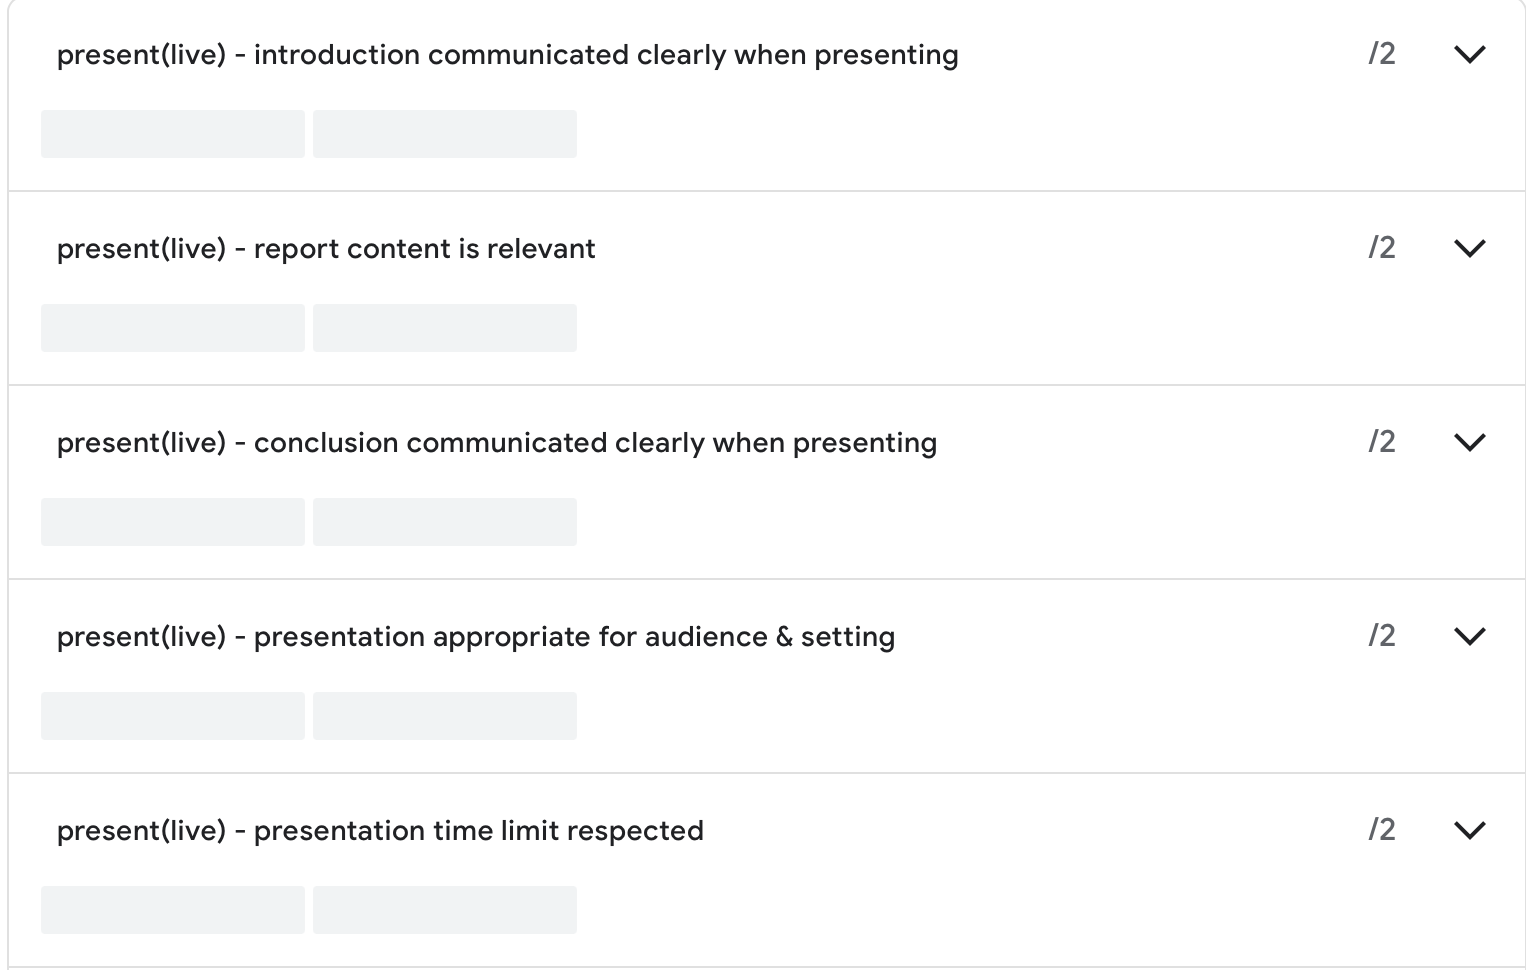